# 1).Problem Statement

### Understanding the properties of product sales at different store

# Loading Packages and Data

In [1]:
#import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
#df_test = pd.read_csv("Test.csv")

In [3]:
df = pd.read_csv("Train.csv")

In [4]:
#df = pd.concat([df_train,df_test])

# Data Structure and Content

In [5]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
df.shape

(8523, 12)

In [7]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
#The described method will help to see how data has been spread for numerical values.
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Exploratory Data Analysis

### Data Consistency

In [10]:
# get all the unique values in the 'Item_Fat_Content' column
Item_Fat_Content_unq =df.Item_Fat_Content.unique()
Item_Fat_Content_unq

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [11]:
# sort them alphabetically and then take a closer look
Item_Fat_Content_unq.sort()
Item_Fat_Content_unq

array(['LF', 'Low Fat', 'Regular', 'low fat', 'reg'], dtype=object)

In [12]:
# convert to lower case
df.Item_Fat_Content = df.Item_Fat_Content.str.lower()
# remove trailing white spaces
df.Item_Fat_Content = df.Item_Fat_Content.str.strip()

## Use fuzzy matching to correct inconsistent data entry
#### We're going to use the fuzzywuzzy package to help identify which strings are closest to each other

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
# helpful modules
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

In [15]:
# get the top 10 closest matches to " low fat"
matches = fuzzywuzzy.process.extract("low fat" ,Item_Fat_Content_unq , limit=5 , scorer=fuzzywuzzy.fuzz.token_sort_ratio)
# take a closer look 
matches

[('Low Fat', 100), ('low fat', 100), ('LF', 22), ('Regular', 14), ('reg', 0)]

In [16]:
# get the top 10 closest matches to " low fat"
matches = fuzzywuzzy.process.extract("regular" ,Item_Fat_Content_unq , limit=5 , scorer=fuzzywuzzy.fuzz.token_sort_ratio)
# take a closer look 
matches

[('Regular', 100), ('reg', 60), ('LF', 22), ('Low Fat', 14), ('low fat', 14)]

In [17]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 22):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")

In [18]:
replace_matches_in_column(df=df, column='Item_Fat_Content', string_to_match="low fat")

All done!


In [19]:
replace_matches_in_column(df=df, column='Item_Fat_Content', string_to_match="regular",min_ratio = 60)

All done!


In [20]:
df.Item_Fat_Content.unique()

array(['low fat', 'regular'], dtype=object)

In [21]:
df.Item_Type.unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [22]:
df.Outlet_Size.unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [23]:
df["Outlet_Size"] = df["Outlet_Size"].str.lower()
df["Outlet_Size"] = df["Outlet_Size"].str.strip()

In [24]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,low fat,0.016047,Dairy,249.8092,OUT049,1999,medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,low fat,0.016760,Meat,141.6180,OUT049,1999,medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,low fat,0.000000,Household,53.8614,OUT013,1987,high,Tier 3,Supermarket Type1,994.7052


# Missing Value Treatment

#### It might be helpful to see what percentage of the values in our dataset were missing to give us a better sense of the scale of this problem:

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [26]:
missing_values_count = df.isnull().sum()
missing_values_count

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## how many total missing values do we have?


In [27]:
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

percentage = (total_missing/total_cells)*100
print(percentage)

3.786812155344362


### Filling in missing values automatically

#### we notice that missing values are only in 2 columns which is "Item_Weight"  and "Outlet_Size "
#### we need to know how to deal with these missing values ( know if there are not exist or not recorded )
#### if we look at these 2 columns we notice that they are just not recorded

In [28]:
(df.Item_Weight.isnull().sum()/df.shape[0])*100

17.165317376510618

In [29]:
(df.Outlet_Size.isnull().sum()/df.shape[0])*100

28.27642848762173

### I think the best practice is
### replace all NA's with the median for the numeric column 
### then replace all the NA's  with the mode for the categorical column 

In [30]:
df.Item_Weight = df.Item_Weight.fillna(df.Item_Weight.mean())

In [31]:
df.Item_Weight.isna().sum()

0

In [32]:
Outlet_Size_mode =  df.Outlet_Size.mode()
Outlet_Size_mode

0    medium
Name: Outlet_Size, dtype: object

In [33]:
df["Outlet_Size"] = df["Outlet_Size"].fillna(method='bfill', axis=0)

In [34]:
df["Outlet_Size"].isna().sum()

0

In [35]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,low fat,0.016047,Dairy,249.8092,OUT049,1999,medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,low fat,0.016760,Meat,141.6180,OUT049,1999,medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,high,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,low fat,0.000000,Household,53.8614,OUT013,1987,high,Tier 3,Supermarket Type1,994.7052


### Remove duplicates

In [36]:
df = df.drop_duplicates()

# Outliers

## IQR (Inter Quartile Range)

In [37]:
#''' Detection '''
# IQR
Q1 = np.percentile(df['Item_MRP'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['Item_MRP'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['Item_MRP']>= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['Item_MRP'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

Old Shape:  (8523, 12)
New Shape:  (8523, 12)


In [38]:
#''' Detection '''
# IQR
Q1 = np.percentile(df['Item_Visibility'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['Item_Visibility'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['Item_Visibility']>= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['Item_Visibility'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

Old Shape:  (8523, 12)
New Shape:  (8379, 12)


In [39]:
#''' Detection '''
# IQR
Q1 = np.percentile(df['Item_Outlet_Sales'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['Item_Outlet_Sales'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['Item_Outlet_Sales']>= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['Item_Outlet_Sales'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

Old Shape:  (8379, 12)
New Shape:  (8193, 12)


# Graphs

<AxesSubplot:xlabel='Item_Weight'>

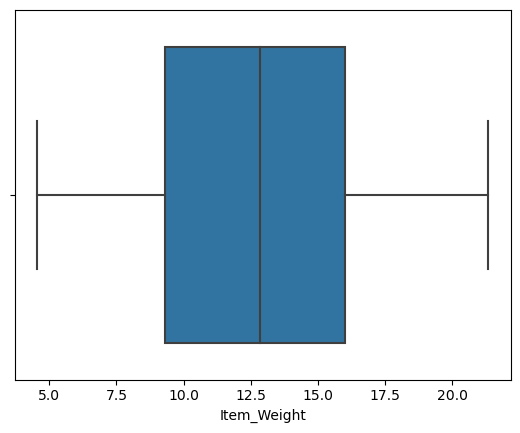

In [40]:
# Box Plot
import seaborn as sns
sns.boxplot(df['Item_Weight'])

<AxesSubplot:xlabel='Item_Visibility'>

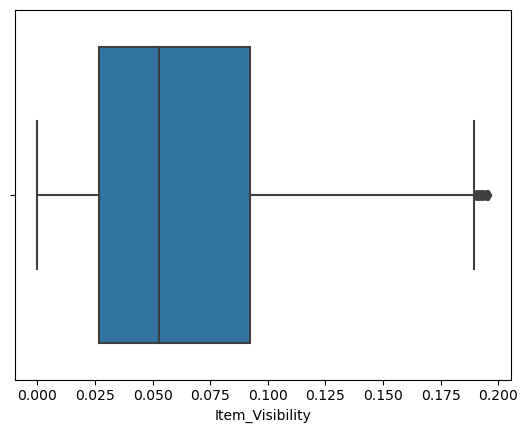

In [41]:
# Box Plot
import seaborn as sns
sns.boxplot(df['Item_Visibility'])

<AxesSubplot:xlabel='Item_Outlet_Sales'>

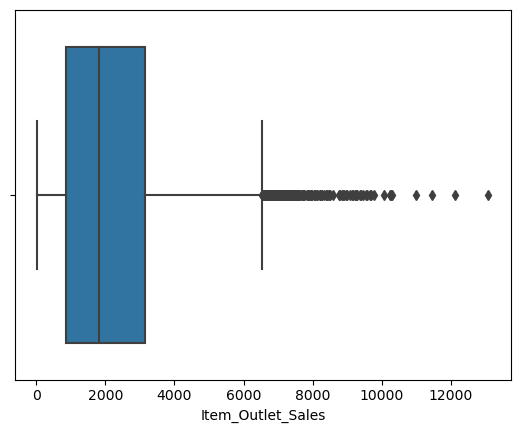

In [42]:
# Box Plot
import seaborn as sns
sns.boxplot(df['Item_Outlet_Sales'])

### C/C : we have removed the outliers in the columns Item_Outlet_Sales and Item_Visibility

# Data Visualization 

Text(0, 0.5, 'Outlet Sales')

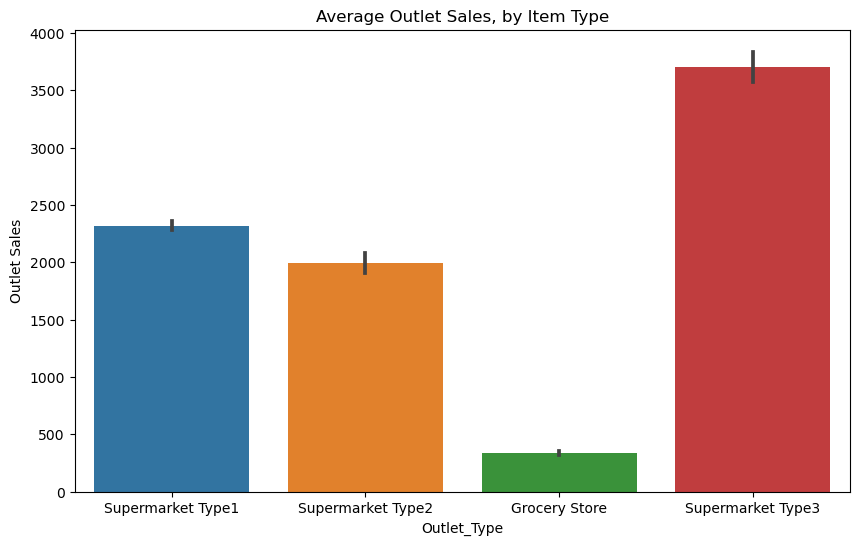

In [43]:
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Average Outlet Sales, by Item Type")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=df.Outlet_Type, y=df['Item_Outlet_Sales'])

# Add label for vertical axis
plt.ylabel("Outlet Sales")

Text(0, 0.5, 'Outlet Sales')

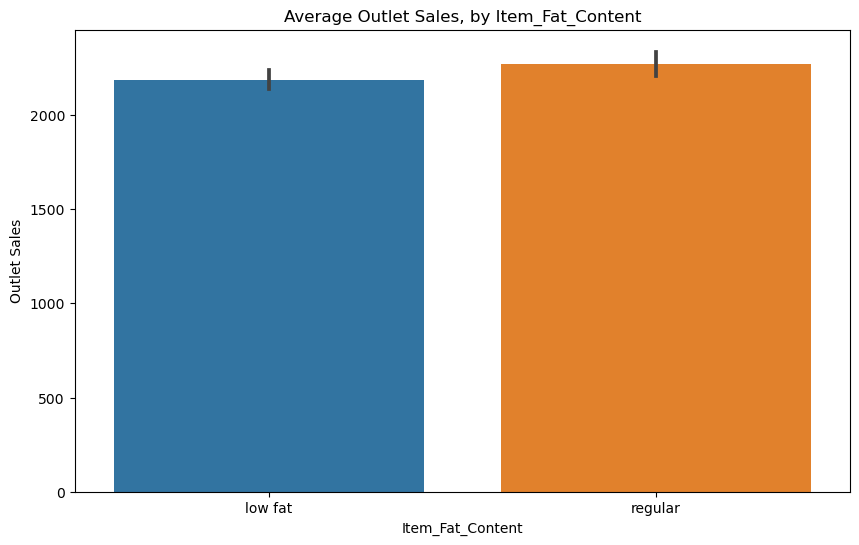

In [44]:
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Average Outlet Sales, by Item_Fat_Content")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=df.Item_Fat_Content, y=df['Item_Outlet_Sales'])

# Add label for vertical axis
plt.ylabel("Outlet Sales")

Text(0, 0.5, 'Outlet Sales')

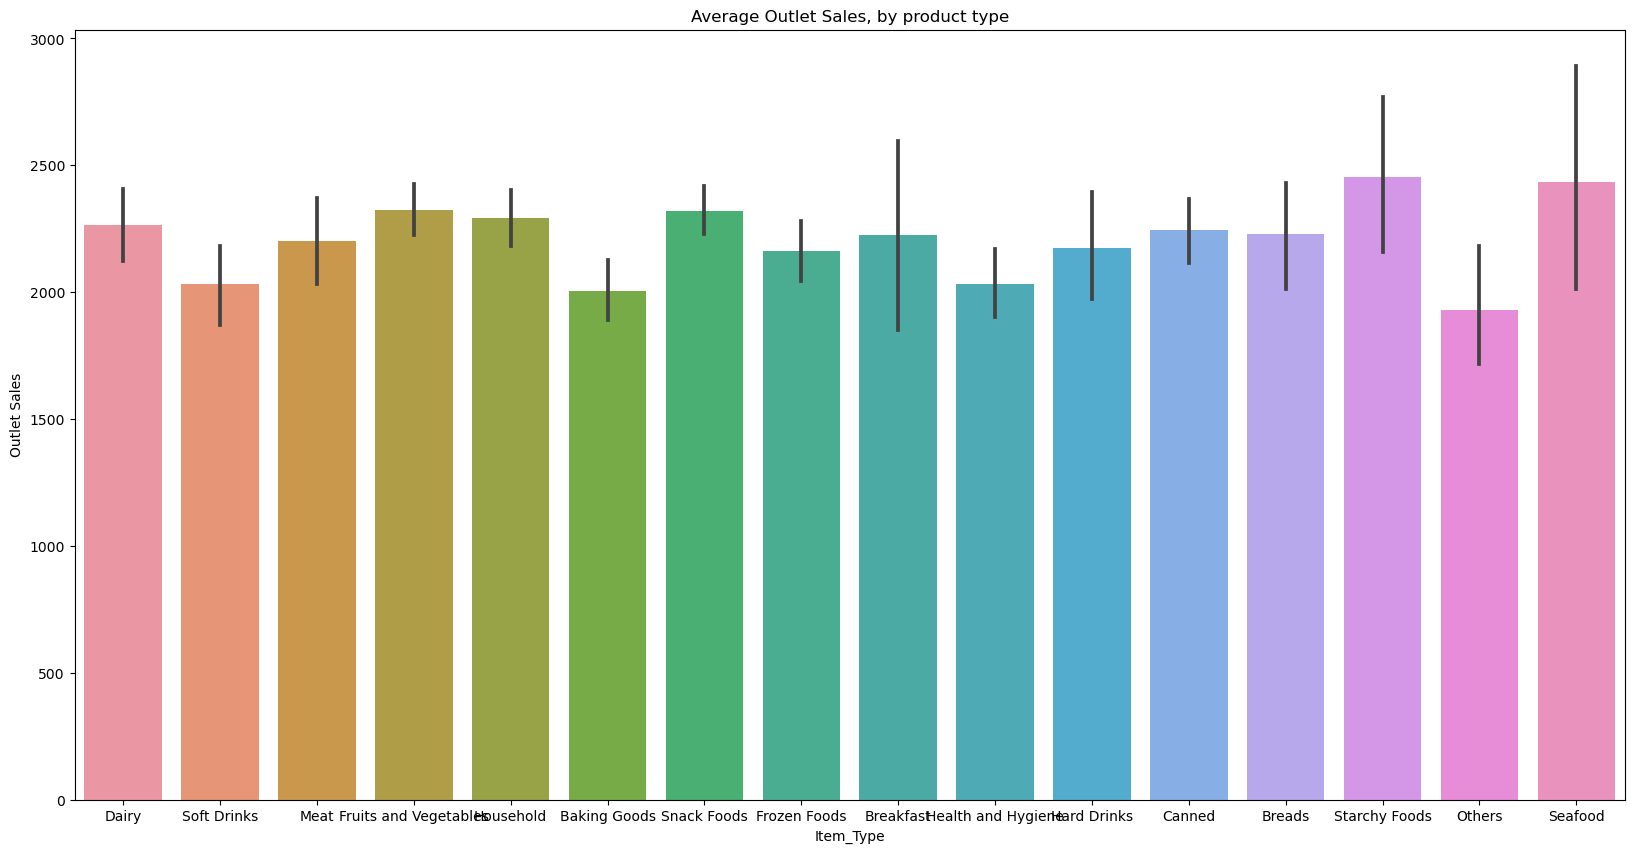

In [45]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Average Outlet Sales, by product type")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=df.Item_Type, y=df['Item_Outlet_Sales'])

# Add label for vertical axis
plt.ylabel("Outlet Sales")

####  we notice that the seafood and Starchy foods are the most product type with high outlet sales 

In [46]:
test= df.groupby(['Item_Fat_Content'])
test.describe()

Item_Weight                                                \
                       count       mean       std    min    25%        50%   
Item_Fat_Content                                                             
low fat               5310.0  12.922776  4.243349  4.590  9.300  12.857645   
regular               2883.0  12.730887  4.228616  4.555  9.395  12.857645   

                              Item_Visibility            ...  \
                   75%    max           count      mean  ...   
Item_Fat_Content                                         ...   
low fat           16.2  21.35          5310.0  0.061424  ...   
regular           15.7  21.20          2883.0  0.066004  ...   

                 Outlet_Establishment_Year         Item_Outlet_Sales  \
                                       75%     max             count   
Item_Fat_Content                                                       
low fat                             2004.0  2009.0            5310.0   
regular                             2004.0  2009.0            2883.0   

                                                                          \
                         mean          std      min       25%        50%   
Item_Fat_Content                                                           
low fat           2186.283071  1700.497820  33.2900  856.8846  1789.6704   
regular           2271.269428  1722.417924  37.2848  918.8040  1869.5664   

                                         
                        75%         max  
Item_Fat_Content                         
low fat           3084.9843  13086.9648  
regular           3257.7594  12117.5600  

[2 rows x 40 columns]

In [47]:
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.007211,0.023374,-0.010582,0.009266
Item_Visibility,-0.007211,1.000000,-0.002648,-0.028088,-0.073174
Item_MRP,0.023374,-0.002648,1.000000,0.006372,0.580562
Outlet_Establishment_Year,-0.010582,-0.028088,0.006372,1.000000,-0.067330
Item_Outlet_Sales,0.009266,-0.073174,0.580562,-0.067330,1.000000


<AxesSubplot:>

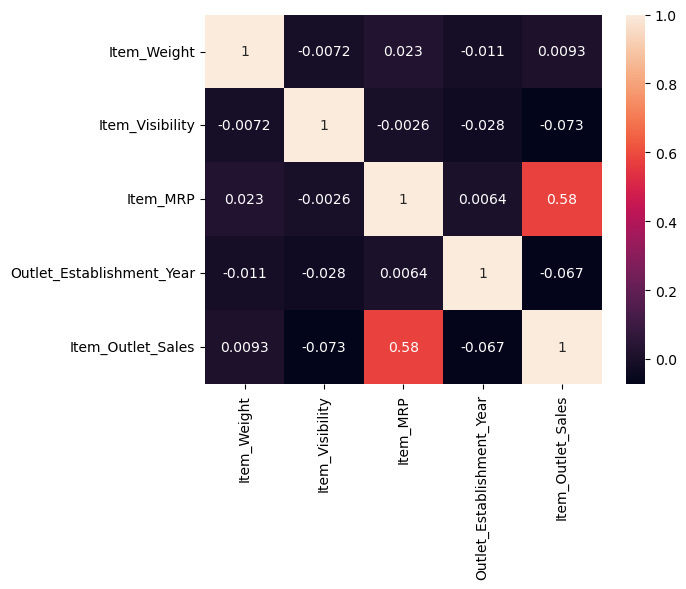

In [48]:
sns.heatmap(df.corr(), annot = True)

# Feature scaling

In [49]:
#from sklearn.preprocessing import StandardScaler

In [50]:
#std_scale=StandardScaler()
#std_scale

In [51]:
#df["Item_Weight"]=std_scale.fit_transform(df[["Item_Weight"]])
#df["Item_Visibility"]=std_scale.fit_transform(df[["Item_Visibility"]])
#df["Outlet_Establishment_Year"]=std_scale.fit_transform(df[["Outlet_Establishment_Year"]])
#df["Item_Outlet_Sales"]=std_scale.fit_transform(df[["Item_Outlet_Sales"]])

In [52]:
#df.head()

In [53]:
df.Outlet_Location_Type.unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

# Converting Categorical To Numerical : ENCODING

In [54]:
#Label Encoding for Ordinal Data
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['Item_Fat_Content']= label_encoder.fit_transform(df['Item_Fat_Content'])
df['Outlet_Size']= label_encoder.fit_transform(df['Outlet_Size'])
df['Outlet_Location_Type']= label_encoder.fit_transform(df['Outlet_Location_Type'])
 
#df_train_transformed = encoder.fit_transform(train_df)

In [55]:
#One Hot Encoding for Nominal Data
import category_encoders as ce
encoder=ce.OneHotEncoder(cols=["Item_Type","Outlet_Type"],handle_unknown='return_nan',return_df=True,use_cat_names=True)

In [56]:
#Fit and transform Data
df = encoder.fit_transform(df)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,Item_Type_Baking Goods,...,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,FDA15,9.30,0,0.016047,1.0,0.0,0.0,0.0,0.0,0.0,...,249.8092,OUT049,1999,1,0,1.0,0.0,0.0,0.0,3735.1380
1,DRC01,5.92,1,0.019278,0.0,1.0,0.0,0.0,0.0,0.0,...,48.2692,OUT018,2009,1,2,0.0,1.0,0.0,0.0,443.4228
2,FDN15,17.50,0,0.016760,0.0,0.0,1.0,0.0,0.0,0.0,...,141.6180,OUT049,1999,1,0,1.0,0.0,0.0,0.0,2097.2700
3,FDX07,19.20,1,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,182.0950,OUT010,1998,0,2,0.0,0.0,1.0,0.0,732.3800
4,NCD19,8.93,0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,53.8614,OUT013,1987,0,2,1.0,0.0,0.0,0.0,994.7052


In [57]:
df.drop(['Item_Identifier', 'Outlet_Identifier'], inplace=True, axis = 1)

# Building ML Model

# Seperating Training And Test Data

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [59]:
X = df.iloc[:,:-1]
y = df.Item_Outlet_Sales

In [60]:
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,Item_Type_Baking Goods,Item_Type_Snack Foods,...,Item_Type_Others,Item_Type_Seafood,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3
0,9.30,0,0.016047,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,249.8092,1999,1,0,1.0,0.0,0.0,0.0
1,5.92,1,0.019278,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,48.2692,2009,1,2,0.0,1.0,0.0,0.0
2,17.50,0,0.016760,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,141.6180,1999,1,0,1.0,0.0,0.0,0.0
3,19.20,1,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,182.0950,1998,0,2,0.0,0.0,1.0,0.0
4,8.93,0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,53.8614,1987,0,2,1.0,0.0,0.0,0.0


In [61]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2 , random_state=42)

# Linear Regression 

In [62]:
reg=LinearRegression()
reg = reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [63]:
print("R squared value: R2",r2_score(y_test,y_pred))
print("Mean Absolute Error :MAE ", mean_absolute_error(y_test,y_pred))
print("Root Mean Squared Error RMSE : ", np.sqrt(mean_squared_error(y_test,y_pred)))

R squared value: R2 0.5372979532861786
Mean Absolute Error :MAE  862.5873061804115
Root Mean Squared Error RMSE :  1157.9779414612372


####  an r-squared of 53% reveals that 53% of the variability observed in the target variable is explained by the regression model. Generally, a higher r-squared indicates more variability is explained by the model.

## Ridge regression: Regularizing coefficients but keeping all features.

In [79]:
from sklearn.linear_model import Ridge
rdg = Ridge(alpha=1.0)
rdg = rdg.fit(X_train, y_train)
yrdg_pred = rdg.predict(X_test)

In [80]:
print("R squared value: R2",r2_score(y_test,yrdg_pred))
print("Mean Absolute Error :MAE ", mean_absolute_error(y_test,yrdg_pred))
print("Root Mean Squared Error RMSE : ", np.sqrt(mean_squared_error(y_test,yrdg_pred)))

R squared value: R2 0.5374220672987355
Mean Absolute Error :MAE  862.3883224942698
Root Mean Squared Error RMSE :  1157.8226245257076


## Lasso regression: Regularizing coefficients to perform feature selection.

In [81]:
from sklearn.linear_model import Lasso
ls = Lasso(alpha=1)
ls = ls.fit(X_train, y_train)
yls_pred = ls.predict(X_test)

In [82]:
print("R squared value: R2",r2_score(y_test,yls_pred))
print("Mean Absolute Error :MAE ", mean_absolute_error(y_test,yls_pred))
print("Root Mean Squared Error RMSE : ", np.sqrt(mean_squared_error(y_test,yls_pred)))

R squared value: R2 0.5397708734136265
Mean Absolute Error :MAE  859.8377381225166
Root Mean Squared Error RMSE :  1154.879377966939


## Elastic nets: Combining Ridge and Lasso regularization.

In [83]:
from sklearn.linear_model import ElasticNet
elsnet= ElasticNet(l1_ratio = 1)
elsnet = elsnet.fit(X_train, y_train)
yelsn_pred = elsnet.predict(X_test)

In [84]:
print("R squared value: R2",r2_score(y_test,yelsn_pred))
print("Mean Absolute Error :MAE ", mean_absolute_error(y_test,yelsn_pred))
print("Root Mean Squared Error RMSE : ", np.sqrt(mean_squared_error(y_test,yelsn_pred)))

R squared value: R2 0.5397708734136265
Mean Absolute Error :MAE  859.8377381225166
Root Mean Squared Error RMSE :  1154.879377966939


## Random Forest Regressor

In [86]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=6, random_state=0)
rf = rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [87]:
print("R squared value: R2",r2_score(y_test,rf_pred))
print("Mean Absolute Error :MAE ", mean_absolute_error(y_test,rf_pred))
print("Root Mean Squared Error RMSE : ", np.sqrt(mean_squared_error(y_test,rf_pred)))

R squared value: R2 0.5777801628845227
Mean Absolute Error :MAE  787.8723015447421
Root Mean Squared Error RMSE :  1106.1624026933307


## XGBoost Regressor

### The two main reasons to use XGBoost are execution speed and model performance.

In [96]:
from sklearn.ensemble import GradientBoostingRegressor
br = GradientBoostingRegressor(random_state=0)
br = br.fit(X_train, y_train)
br_pred = br.predict(X_test)

In [97]:
print("R squared value: R2",r2_score(y_test,br_pred))
print("Mean Absolute Error :MAE ", mean_absolute_error(y_test,br_pred))
print("Root Mean Squared Error RMSE : ", np.sqrt(mean_squared_error(y_test,br_pred)))

R squared value: R2 0.5764311580608359
Mean Absolute Error :MAE  787.7636115284448
Root Mean Squared Error RMSE :  1107.928104190283
